[Please see the first chapter where getting the data and processing RNA modality are described](https://github.com/gtca/multi-omics-tutorials/blob/master/single-cell-rna-atac/pbmc10k/1-Gene-Expression-Processing.ipynb)


This is the second chapter of the multimodal single-cell gene expression and chromatin accessibility analysis. In this notebook, scATAC-seq data processing is described.

The flow of this notebook is similar to the scRNA-seq one, and we use rather similar data normalisation strategy to process the cells by peaks matrix. Alternative normalisation strategies are discussed elsewhere.

In [1]:
# Change directory to the root folder of the repository
import os
os.chdir("../../")

# Load libraries and data

Import libraries:

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

In [3]:
import muon as mu

# Import a module with ATAC-seq-related functions
from muon import atac as ac

Load the MuData object from the `.h5mu` file that was saved at the end of the previous chapter:

In [4]:
mdata = mu.read("data/pbmc10k.h5mu")
mdata

MuData object with n_obs × n_vars = 11909 × 134733
  2 modalities
    atac:	11909 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'
    rna:	11852 x 26346
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

# ATAC

In this notebook, we will only work with the Peaks modality and will use the ATAC module of muon.

We will refer to the `atac` AnnData inside the MuData by defining a respective variable:

In [5]:
atac = mdata.mod['atac']
atac  # an AnnData object

AnnData object with n_obs × n_vars = 11909 × 108377
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'atac', 'files'

## Preprocessing

To filter and to normalise the data, we are going to use the same scanpy functionality as we use when working with gene expression. The only thing to bear in mind here that a _gene_ would mean a _peak_ in the context of the AnnData object with ATAC-seq data.

### QC

Perform some quality control filtering out cells with too few peaks and peaks detected in too few cells. For now, we will filter out cells that do not pass QC.

Some mild pre-filtering first:

In [6]:
sc.pp.filter_cells(atac, min_genes=500)  # peaks
sc.pp.filter_cells(atac, min_counts=500)

sc.pp.filter_genes(atac, min_cells=10)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


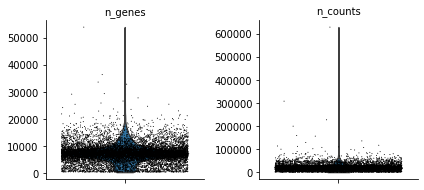

In [7]:
sc.pl.violin(atac, ['n_genes', 'n_counts'], jitter=0.4, multi_panel=True)

Perform actual filtering:

In [8]:
sc.pp.filter_cells(atac, max_genes=15000)
sc.pp.filter_cells(atac, max_counts=40000)

sc.pp.filter_cells(atac, min_genes=2000)
sc.pp.filter_cells(atac, min_counts=4000)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Let's see how the data looks after filtering:

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


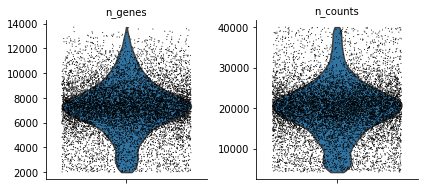

In [9]:
sc.pl.violin(atac, ['n_genes', 'n_counts'], jitter=0.4, multi_panel=True)

### Normalisation

In [10]:
# Save original counts
atac.layers["counts"] = atac.X

There can be multiple options for ATAC-seq data normalisation.

One is [latent semantic indexing](https://en.wikipedia.org/wiki/Latent_semantic_analysis) that is frequently used for processing ATAC-seq datasets. First, it constructs term-document matrix from the original count matrix. Then the singular value decomposition (SVD) — the same technique that convential principal component analysis uses — is used to generate LSI components. Note that there are different flavours of computing TF-IDF, e.g. see [this blog post](http://andrewjohnhill.com/blog/2019/05/06/dimensionality-reduction-for-scatac-data/) about that.

This is implemented in the `muon`'s ATAC module:

```py
ac.pp.tfidf(atac, scale_factor=1e4)
```

Here we will use the same log-normalisation and PCA that we are used to from scRNA-seq analysis. We notice on this data it yields PC & UMAP spaces similar to the one generated on scRNA-seq counts.

In [11]:
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [12]:
sc.pp.log1p(atac)

### Feature selection

We will label highly variable peaks that we'll use for downstream analysis.

In [22]:
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)

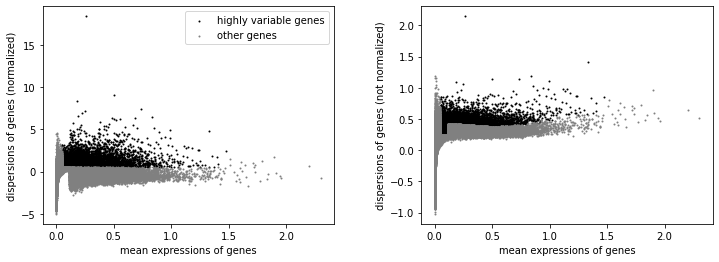

In [23]:
sc.pl.highly_variable_genes(atac)

In [24]:
np.sum(atac.var.highly_variable)

14896

### Scaling

For uniformity, and for consequent visualisation, we'll save log-transformed counts in a `.raw` slot:

In [25]:
atac.raw = atac

## Analysis

After filtering out low-quality cells, normalising the counts matrix, and selecting highly varianbe peaks, we can already use this data for multimodal integration.

However, as in the case of gene expression, we will study this data individually first and will run PCA on the scaled matrix, compute cell neighbourhood graph, and perform clustering to define cell types. This might be useful later to compare cell type definition between modalities.

### LSI

When working on TF-IDF counts, `sc.tl.pca` or `ac.tl.lsi` can be used to get latent components, e.g.:

```py
ac.tl.lsi(atac)
```

We find the first component is typically associated with number of peaks or counts per cell so it is reasonable to remove it:

```py
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:]
```

The respective neighbourhood graph can be generated with `sc.tl.neighbors`:

```py
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30) 
```

### PCA

In [29]:
sc.pp.scale(atac)
sc.tl.pca(atac)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [30]:
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=30)

We can only colour our plots by cut counts in individual peaks with scanpy:

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


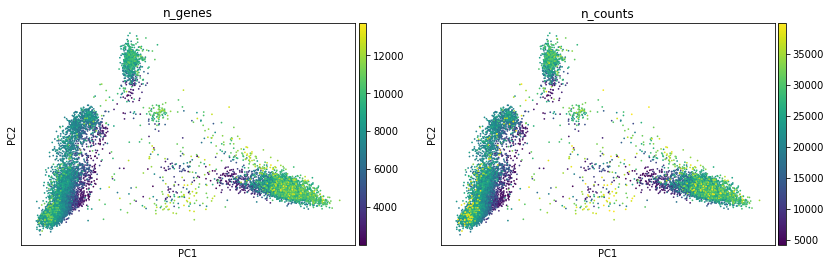

In [31]:
sc.pl.pca(atac, color=["n_genes", "n_counts"])

With muon's ATAC module, we can plot average values for cut counts in peaks of different types (promoter/distal) that are assigned to respective genes — just by providing gene names.

For that to work, we need the peak annotation table with `gene -> peak` correspondence. The `peak_annotation.tsv` file was detected and loaded automatically when we loaded the original data. Here is how the processed peak annotation table looks like:

In [34]:
atac.uns['atac']['peak_annotation'].tail()

# Alternatively add peak annotation from a TSV file
# ac.tl.add_peak_annotation(atac, annotation="data/pbmc10k/atac_peak_annotation.tsv")

,gene,peak,distance,peak_type
gene_name,,,,
AC024558.2,ENSG00000288436,chr3:126607163-126607753,802,distal
AL138899.3,ENSG00000288460,chr1:158113208-158113983,14318,distal
AL138899.3,ENSG00000288460,chr1:158115189-158115461,12840,distal
AL138899.3,ENSG00000288460,chr1:158118041-158118134,10167,distal
AL138899.3,ENSG00000288460,chr1:158124927-158125417,2884,distal


Now we can plot average cut values in peaks corresponding to genes just by providing a gene name. By default, values in `atac.raw` are used for plotting.

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


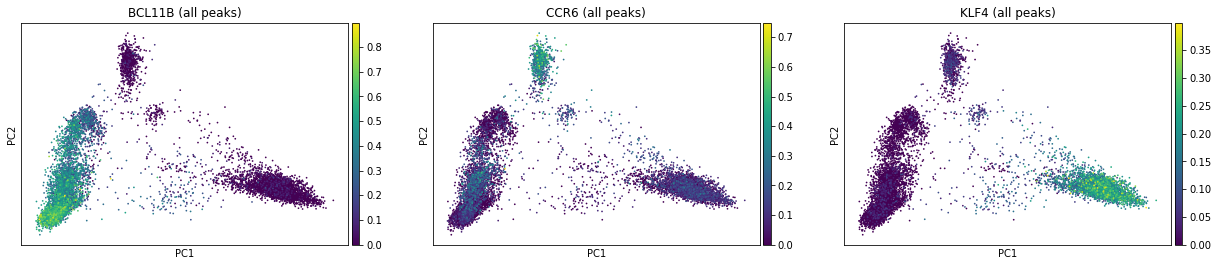

In [35]:
ac.pl.pca(atac, color=["BCL11B", "CCR6", "KLF4"], average="total")

We can also average peaks of each type separately:

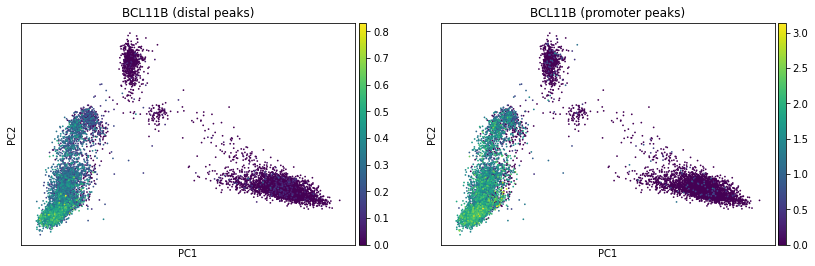

In [263]:
ac.pl.pca(atac, color="BCL11B", average="peak_type")

We see how this component space here resembles the one based on gene expression from the previous notebook. Looking at top loadings of first two components, we see how peaks linked to BCL11B (ENSG00000127152) and KLF4 (ENSG00000136826) demarcate lympohoid / myeloid axis while peaks linked to CCR6 (ENSG00000112486) define B cell axis.

Now we will compute a neighbourhood graph for cells that we'll use for clustering later on.

In [39]:
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=30)

### Non-linear dimensionality reduction and clustering

To stay comparable to the gene expression notebook, we will use `leiden` to cluster cells.

In [17]:
sc.tl.leiden(atac, resolution=.4)

We'll use UMAP latent space for visualisation below.

In [37]:
sc.tl.umap(atac, spread=1., min_dist=.5, random_state=10)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


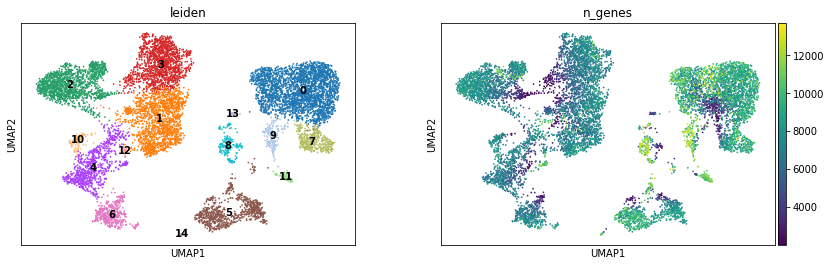

In [18]:
sc.pl.umap(atac, color=["leiden", "n_genes"], legend_loc="on data")

We will again use the functionality of the ATAC module in `muon` to color plots by cut values in peaks correspoonding to a certain gene:

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


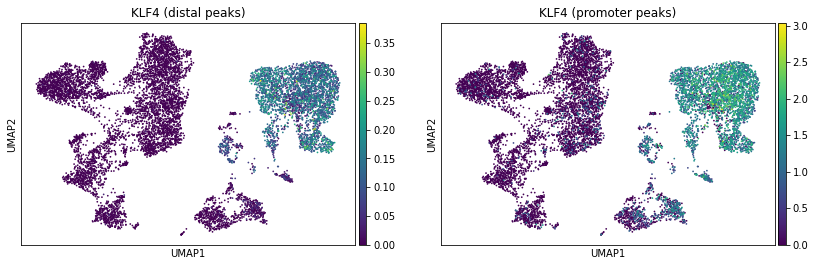

In [40]:
ac.pl.umap(atac, color=["KLF4"], average="peak_type")

### Marker genes and celltypes

We will now define cell types based on chromatin accessibility.

In [46]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')

In [47]:
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option("max_columns", 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'genes', 'pvals']}).head(10)

,0_n,0_g,0_p,1_n,1_g,1_p,2_n,2_g,2_p,3_n,3_g,3_p,4_n,4_g,4_p,5_n,5_g,5_p,6_n,6_g,6_p,7_n,7_g,7_p,8_n,8_g,8_p,9_n,9_g,9_p,10_n,10_g,10_p,11_n,11_g,11_p,12_n,12_g,12_p,13_n,13_g,13_p,14_n,14_g,14_p
0,chr9:107480158-107492721,KLF4,0.0,chr14:22536559-22563070,"TRAJ7, TRAJ6, TRAJ5, TRAJ4, TRAJ3, TRAJ2, TRAJ...",7.482031e-245,chr2:86783559-86792275,CD8A,6.143212e-320,chr14:99255246-99275454,"BCL11B, AL109767.1",2.180904e-232,chr1:24909406-24919504,RUNX3,5.755049e-142,chr22:41917087-41929835,TNFRSF13C,1.355350e-258,chr17:83076201-83103570,"METRNL, AC130371.2",2.896838e-139,chr19:18167172-18177541,"PIK3R2, IFI30",5.991020e-86,chr9:107480158-107492721,KLF4,1.087500e-09,chr9:107480158-107492721,KLF4,1.300289e-41,chr11:114072228-114076352,ZBTB16,7.670771e-23,chr17:81425658-81431769,BAHCC1,8.694050e-34,chr16:88448143-88480965,ZFPM1,2.747879e-10,chr10:133265906-133281093,"TUBGCP2, ADAM8",4.538240e-08,chr22:22926399-22936461,IGLC7,2.602094e-08
1,chr11:61953652-61974246,"BEST1, FTH1",0.0,chr14:99255246-99275454,"BCL11B, AL109767.1",4.434150e-164,chr14:99255246-99275454,"BCL11B, AL109767.1",5.440339e-275,chr14:99223600-99254668,"BCL11B, AL109767.1",2.162926e-185,chr4:6198055-6202103,"JAKMIP1, C4orf50",9.266573e-117,chr22:41931503-41942227,CENPM,1.842013e-249,chr1:24909406-24919504,RUNX3,1.340264e-90,chr9:134369462-134387253,RXRA,9.005707e-81,chr2:218361880-218373051,"CATIP, CATIP-AS1",2.306010e-08,chr3:4975862-4990757,"BHLHE40, BHLHE40-AS1",1.027061e-41,chr22:44709028-44711972,PRR5,1.230670e-22,chr17:3910107-3919628,P2RX1,1.222272e-29,chr22:39087900-39092994,APOBEC3H,6.072950e-08,chr19:21593423-21595308,AC123912.2,1.443596e-07,chr10:110353286-110359160,SMNDC1,5.102885e-07
2,chr20:50269694-50277398,SMIM25,0.0,chr10:8041366-8062418,"GATA3, GATA3-AS1, AL390294.1",3.628896e-157,chr11:66311352-66319301,"CD248, AP001107.3",1.352583e-252,chr14:99181080-99219442,"BCL11B, AL162151.1",2.352130e-159,chr2:241762278-241764383,"D2HGDH, AC114730.2",7.295551e-116,chr19:5125450-5140568,"KDM4B, AC022517.1",3.808650e-211,chr2:28388837-28416648,"FOSL2, AC104695.2, AC104695.4",5.215740e-87,chr5:1476663-1483241,"SLC6A3, LPCAT1",4.236145e-76,chr9:134369462-134387253,RXRA,1.643032e-07,chr1:220876295-220883526,"HLX, HLX-AS1",4.949660e-34,chr16:81519063-81525049,CMIP,1.534259e-22,chr12:108627138-108639115,"SELPLG, AC007569.1",5.350324e-28,chr5:35850992-35860227,IL7R,4.730867e-07,chr17:82211956-82220400,"CCDC57, AC132872.2",4.006492e-06,chr1:117653309-117657455,TENT5C,1.223869e-06
3,chr9:134369462-134387253,RXRA,0.0,chr7:142782798-142813716,"TRBC1, TRBJ2-1, TRBJ2-2, TRBJ2-2P, TRBJ2-3, TR...",4.545817e-146,chr12:10552886-10555668,LINC02446,5.946484e-217,chr7:142782798-142813716,"TRBC1, TRBJ2-1, TRBJ2-2, TRBJ2-2P, TRBJ2-3, TR...",1.778042e-155,chr20:24948563-24956577,CST7,1.078312e-116,chr2:231669797-231676530,PTMA,2.531730e-203,chr1:184386243-184389335,"C1orf21, AL445228.2",3.798585e-78,chr20:40686526-40691350,MAFB,1.609811e-73,chr11:1777309-1784076,AC068580.2,2.574174e-07,chr5:150385442-150415310,"CD74, TCOF1",1.372640e-31,chr15:39623205-39625650,"FSIP1, AC037198.2",1.149120e-21,chr22:50281096-50284890,PLXNB2,3.843165e-27,chr19:16363226-16378669,"EPS15L1, AC020917.3",1.841814e-06,chr17:75771404-75787641,"H3F3B, UNK",4.607572e-06,chr2:181303834-181310073,LINC01934,4.285368e-06
4,chr22:38950570-38958424,APOBEC3A,0.0,chr20:59157931-59168100,ZNF831,3.574567e-130,chr2:136122469-136138482,CXCR4,2.434415e-223,chr14:22536559-22563070,"TRAJ7, TRAJ6, TRAJ5, TRAJ4, TRAJ3, TRAJ2, TRAJ...",2.089929e-156,chr2:144507361-144525092,"ZEB2, LINC01412, ZEB2-AS1, AC009951.6",1.708342e-114,chr5:150385442-150415310,"CD74, TCOF1",3.348203e-198,chr20:24948563-24956577,CST7,4.163680e-76,chr2:16653069-16660704,FAM49A,1.741139e-72,chr20:50269694-50277398,SMIM25,5.053578e-07,chr17:81044486-81052618,BAIAP2,1.508115e-28,chr20:35250675-35252861,MMP24,3.708801e-21,chr6:11730442-11733107,"ADTRP, AL022724.3",8.037829e-27,chr5:134110288-134135061,TCF7,2.542328e-06,chr9:91419015-91426704,"NFIL3, AL353764.

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


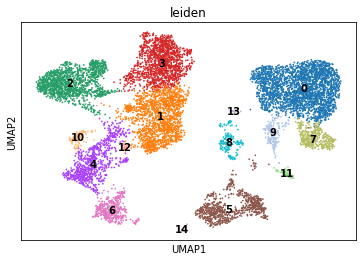

In [48]:
sc.pl.umap(atac, color="leiden", legend_loc="on data")

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


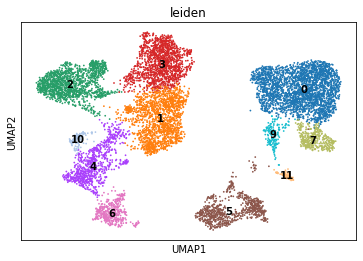

In [228]:
sc.pl.umap(atac, color="leiden", legend_loc="on data")

Having studied markers of individual clusters, we will filter some cells out before assigning cell types names to clusters.

In [19]:
atac = atac[~atac.obs.leiden.isin(["8", "12", "13", "14"])]

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [229]:
new_cluster_names = [
    'mono CD14+', 'T CD4+ memory', 'T CD8+ naïve', 
    'T CD4+ naïve', 'T CD8+ activated', 'B',
    'NK', 'mono CD16+', 'mDC',
    'MAIT', 'pDC']
atac.obs['celltype'] = atac.obs.leiden.values
atac.rename_categories('celltype', new_cluster_names)

We will also re-order categories for the next plots:

In [230]:
atac.obs.celltype.cat.reorder_categories([
    'T CD4+ naïve', 'T CD4+ memory', 'MAIT',
    'T CD8+ naïve', 'T CD8+ activated', 
    'NK', 'B',
    'mono CD14+', 'mono CD16+',
    'mDC', 'pDC'], inplace=True)

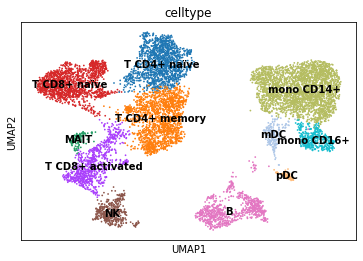

In [232]:
sc.pl.umap(atac, color="celltype", legend_loc="on data")

Finally, we'll visualise some marker genes across cell types.

In [258]:
marker_genes = ['IL7R', 'TRAC',
                'GATA3',
                'SLC4A10',
                'CD8A', 'CD8B', 'CD248', 'CCL5',
                'GNLY', 'NKG7',
                'CD79A', 'MS4A1', 'IGHD', 'TNFRSF13C',
                'IL4R', 'KLF4', 'LYZ', 'S100A8', 'CD14', 
                'FCGR3A', 'MS4A7', 'CST3',
                'IRF8', 'TCF4']

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


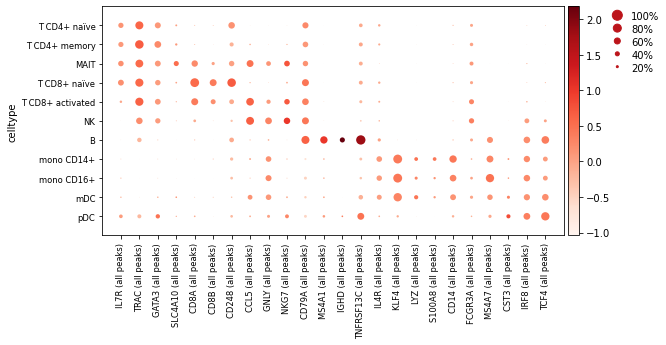

In [259]:
ac.pl.dotplot(atac, marker_genes, groupby='celltype')

# Saving progress on disk

In this chapter, we have been working on the ATAC modality only. We can save our progress into the `.h5mu` file. That will only update the ATAC modality inside the file.

In [262]:
mu.write("data/pbmc10k.h5mu/atac", atac)

[Next, we'll look into multimodal omics data integration.](https://github.com/gtca/multi-omics-tutorials/blob/master/single-cell-rna-atac/pbmc10k/3-Multimodal-Omics-Data-Integration.ipynb)
